In [1]:
# Cell 1: Imports (Add LSTM)
import pandas as pd
import os
import numpy as np
import cv2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from functools import lru_cache
import matplotlib.pyplot as plt
%matplotlib inline

# Global variables
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
IMAGE_CHANNELS = 3
BATCH_SIZE = 16
TIMESTEPS = 24  # Number of images in a sequence (e.g., 24 hours)
EPHOCHS_SIZE=200


In [2]:
@lru_cache(maxsize=10000)
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image at {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))

def load_images_with_data(image_dir="F:/Pheonix/Thesis/Project/Code/AQI Index/.venv/Dev/Data/cleaned_folder",
                         csv_file="F:/Pheonix/Thesis/Project/Code/AQI Index/.venv/Dev/Data/cleaned_data.csv"):
    df = pd.read_csv(csv_file)
    image_data_list = []
    
    for _, row in df.iterrows():
        image_name = row['Filename']
        image_path = os.path.join(image_dir, image_name)
        if os.path.exists(image_path):
            try:
                img_resized = load_and_preprocess_image(image_path)
                print(f"Loaded image {image_name} shape: {img_resized.shape}")
                values = row.to_dict()
                values['image'] = img_resized
                image_data_list.append(values)
            except Exception as e:
                print(f"Error loading image {image_name}: {e}")
        else:
            print(f"Warning: Image '{image_name}' not found in '{image_dir}'.")
    return image_data_list

image_data_list = load_images_with_data()
#print(f"Loaded {len(image_data_list)} images")

Loaded image BRI_Un_2023-02-02- 12.00-9.jpg shape: (32, 32, 3)
Loaded image BRI_Un_2023-02-02- 12.00-8.jpg shape: (32, 32, 3)
Loaded image BRI_Un_2023-02-02- 12.00-7.jpg shape: (32, 32, 3)
Loaded image BRI_Un_2023-02-02- 12.00-6.jpg shape: (32, 32, 3)
Loaded image BRI_Un_2023-02-02- 12.00-5.jpg shape: (32, 32, 3)
Loaded image BRI_Un_2023-02-02- 12.00-4.jpg shape: (32, 32, 3)
Loaded image BRI_Un_2023-02-02- 12.00-3.jpg shape: (32, 32, 3)
Loaded image BRI_Un_2023-02-02- 12.00-2.jpg shape: (32, 32, 3)
Loaded image BRI_Un_2023-02-02- 12.00-18.jpg shape: (32, 32, 3)
Loaded image BRI_Un_2023-02-02- 12.00-17.jpg shape: (32, 32, 3)
Loaded image BRI_Un_2023-02-02- 12.00-16.jpg shape: (32, 32, 3)
Loaded image BRI_Un_2023-02-02- 12.00-15.jpg shape: (32, 32, 3)
Loaded image BRI_Un_2023-02-02- 12.00-14.jpg shape: (32, 32, 3)
Loaded image BRI_Un_2023-02-02- 12.00-13.jpg shape: (32, 32, 3)
Loaded image BRI_Un_2023-02-02- 12.00-12.jpg shape: (32, 32, 3)
Loaded image BRI_Un_2023-02-02- 12.00-11.jpg sha

In [3]:
@lru_cache(maxsize=1000)
def segment_sky(image_tuple):
    image = np.array(image_tuple, dtype=np.uint8).reshape(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower_sky = np.array([60, 20, 20])
    upper_sky = np.array([150, 255, 255])
    mask = cv2.inRange(hsv, lower_sky, upper_sky)
    return cv2.bitwise_and(image, image, mask=mask)

def prepare_dataset(image_data_list):
    """Prepare dataset as sequences for LSTM with padding for incomplete sequences."""
    X = []
    y_dict = {'AQI': [], 'PM2.5': [], 'PM10': [], 'O3': [], 'CO': [], 'SO2': [], 'NO2': []}
    sequence_X = []
    
    for i, data in enumerate(image_data_list):
        img = data['image']
        if img.shape != (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS):
            img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
        
        img_tuple = tuple(img.ravel())
        sky_img = segment_sky(img_tuple)
        sky_img = preprocess_input(sky_img)
        if sky_img.shape != (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS):
            sky_img = cv2.resize(sky_img, (IMAGE_WIDTH, IMAGE_HEIGHT))
        
        sequence_X.append(sky_img)
        for param in y_dict.keys():
            y_dict[param].append(data[param])
        
        # Group into sequences of TIMESTEPS
        if (i + 1) % TIMESTEPS == 0:
            X.append(np.array(sequence_X))
            sequence_X = []
    
    # Handle remaining data (pad if incomplete)
    if sequence_X:
        remaining_steps = TIMESTEPS - len(sequence_X)
        if remaining_steps > 0:
            # Pad with zeros
            padding = np.zeros((remaining_steps, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.float32)
            sequence_X = np.concatenate([np.array(sequence_X), padding], axis=0)
        X.append(sequence_X)
    
    X = np.array(X)  # Shape: (n_sequences, TIMESTEPS, 224, 224, 3)
    
    # Prepare y_dict as sequences
    y_dict_seq = {}
    for param, values in y_dict.items():
        sequences = [values[i:i+TIMESTEPS] for i in range(0, len(values), TIMESTEPS)]
        # Pad y sequences to match TIMESTEPS
        if len(sequences[-1]) < TIMESTEPS:
            sequences[-1] = np.pad(sequences[-1], (0, TIMESTEPS - len(sequences[-1])), mode='constant', constant_values=0)
        y_dict_seq[param] = np.array(sequences)
    
    print(f"Final X shape: {X.shape}, y_dict keys: {list(y_dict_seq.keys())}")
    return X, y_dict_seq

X, y_dict = prepare_dataset(image_data_list)
print(f"Dataset shape: X={X.shape}, y_dict sample shape: {y_dict['AQI'].shape}")

Final X shape: (443, 24, 32, 32, 3), y_dict keys: ['AQI', 'PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'NO2']
Dataset shape: X=(443, 24, 32, 32, 3), y_dict sample shape: (443, 24)


In [4]:
def build_cnn_lstm_model(input_shape=(TIMESTEPS, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)):
    """Build a CNN-LSTM hybrid model."""
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
    base_model.trainable = False
    
    model = Sequential([
        # TimeDistributed applies CNN to each timestep
        TimeDistributed(base_model, input_shape=input_shape),
        TimeDistributed(Flatten()),
        LSTM(128, return_sequences=False),  # LSTM processes sequence of CNN features
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1)  # Predict one value per sequence (e.g., final timestep)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_cnn_lstm_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 24, 1, 1, 512)    14714688  
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 24, 512)          0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               328192    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [5]:
def train_models(X, y_dict):
    """Train CNN-LSTM models."""
    models = {}
    histories = {}
    
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        brightness_range=[0.8, 1.2],
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    for param, y_values in y_dict.items():
        print(f"\nTraining model for {param}")
        # Split sequences
        X_train, X_test, y_train, y_test = train_test_split(X, y_values, test_size=0.2, random_state=42)
        print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")
        print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        
        model = build_cnn_lstm_model()
        history = model.fit(
            X_train, y_train[:, -1],  # Predict last timestep (or adjust for full sequence)
            validation_data=(X_test, y_test[:, -1]),
            epochs=EPHOCHS_SIZE,
            batch_size=BATCH_SIZE,
            callbacks=[early_stopping],
            verbose=1
        )
        models[param] = model
        histories[param] = history
    return models, histories

models, histories = train_models(X, y_dict)


Training model for AQI
Training samples: 354, Testing samples: 89
X_train shape: (354, 24, 32, 32, 3), y_train shape: (354, 24)
Epoch 1/200
23/23 [==============================] - 15s 270ms/step - loss: 40276.9336 - mae: 167.2021 - val_loss: 30451.8398 - val_mae: 143.3722
Epoch 2/200
23/23 [==============================] - 2s 88ms/step - loss: 36973.4453 - mae: 156.8071 - val_loss: 26095.1406 - val_mae: 127.7863
Epoch 3/200
23/23 [==============================] - 2s 86ms/step - loss: 30920.2969 - mae: 136.7917 - val_loss: 20309.2109 - val_mae: 106.6511
Epoch 4/200
23/23 [==============================] - 2s 86ms/step - loss: 23912.4043 - mae: 116.0750 - val_loss: 14798.2783 - val_mae: 85.3807
Epoch 5/200
23/23 [==============================] - 2s 86ms/step - loss: 18496.5820 - mae: 100.2901 - val_loss: 11257.4971 - val_mae: 71.9077
Epoch 6/200
23/23 [==============================] - 2s 94ms/step - loss: 14745.7666 - mae: 89.1228 - val_loss: 9742.7666 - val_mae: 69.0375
Epoch 7/20

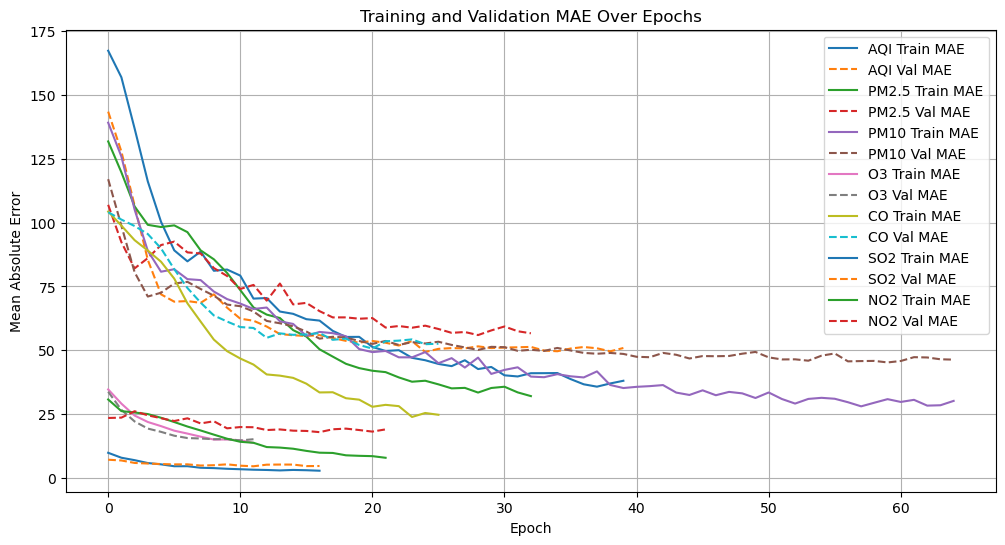

In [6]:
plt.figure(figsize=(12, 6))
for param, history in histories.items():
    plt.plot(history.history['mae'], label=f'{param} Train MAE')
    plt.plot(history.history['val_mae'], label=f'{param} Val MAE', linestyle='--')
plt.title('Training and Validation MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
def test_model(models, X_test=None, y_test_dict=None, new_image_path=None):
    results = {}
    
    if X_test is not None and y_test_dict is not None:
        print(f"\nEvaluating on test data (sequences: {X_test.shape[0]})")
        for param, model in models.items():
            test_loss, test_mae = model.evaluate(X_test, y_test_dict[param][:, -1], verbose=0)
            y_pred = model.predict(X_test, verbose=0).flatten()
            r2 = r2_score(y_test_dict[param][:, -1], y_pred)
            results[param] = {'MSE': test_loss, 'MAE': test_mae, 'R²': r2}
            print(f"{param} - Test MSE: {test_loss:.4f}, Test MAE: {test_mae:.4f}, R²: {r2:.4f}")
    
    elif new_image_path is not None:
        print("\nPredicting for a new sequence (single image assumed):")
        img_resized = load_and_preprocess_image(new_image_path)
        img_tuple = tuple(img_resized.ravel())
        sky_img = segment_sky(img_tuple)
        sky_img = preprocess_input(sky_img)
        # Simulate a sequence with one timestep
        sky_img_seq = np.expand_dims(sky_img, axis=0)  # (1, 224, 224, 3)
        sky_img_seq = np.repeat(sky_img_seq[np.newaxis, :], TIMESTEPS, axis=1)  # (1, TIMESTEPS, 224, 224, 3)
        
        for param, model in models.items():
            pred = model.predict(sky_img_seq, verbose=0)[0]
            results[param] = pred
            print(f"Predicted {param}: {pred[0]:.4f}")
    
    else:
        raise ValueError("Provide either test data or new_image_path")
    return results

X_train, X_test, y_train_dict, y_test_dict = {}, {}, {}, {}
for param, y_values in y_dict.items():
    X_train[param], X_test[param], y_train_dict[param], y_test_dict[param] = train_test_split(
        X, y_values, test_size=0.2, random_state=42
    )

test_results = test_model(models, X_test['AQI'], y_test_dict)
new_image = "F:\Pheonix\Thesis\Project\jupiterNotebook\BENGR_Good_2023-02-19-08.30-1-3.jpg"
pred_results = test_model(models, new_image_path=new_image)


Evaluating on test data (sequences: 89)
AQI - Test MSE: 5346.7144, Test MAE: 49.6443, R²: 0.4577
PM2.5 - Test MSE: 7164.2803, Test MAE: 57.1719, R²: 0.5469
PM10 - Test MSE: 3898.8455, Test MAE: 45.2689, R²: 0.6440
O3 - Test MSE: 436.7494, Test MAE: 15.6909, R²: 0.3900
CO - Test MSE: 6374.2544, Test MAE: 50.6938, R²: 0.5953
SO2 - Test MSE: 40.5211, Test MAE: 4.6526, R²: 0.4351
NO2 - Test MSE: 676.8410, Test MAE: 18.0027, R²: 0.4322

Predicting for a new sequence (single image assumed):
Predicted AQI: 72.5990
Predicted PM2.5: 34.1410
Predicted PM10: 46.3184
Predicted O3: 25.5666
Predicted CO: 237.4479
Predicted SO2: 7.4451
Predicted NO2: 17.9174
